In [1]:
import os
os.chdir('../')

## Imports

In [2]:
import pandas as pd

from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score

from src.develop.feature_importance import ShapValues
from src.develop.cross_validation import CrossValidation

from src.train import ClassificationModel, TwoStepCalibration

# shap.initjs()
# warnings
import warnings
warnings.filterwarnings('ignore')

## Data Collect

In [14]:
df_model = pd.read_csv("notebooks/outputs/df_model_2.csv")
df_model["dt_calendar"] = pd.to_datetime(df_model["dt_calendar"])

print(df_model.shape)
df_model.head()

(4836, 21)


,dt_calendar,id_imobiliaria,lat_imob,long_imob,is_active,is_activated,is_commun_first_90days,is_debelado,is_debelado_first_4months,is_indemnified,...,is_indemn_first_6months,vl_locacao,is_churn,exonerated_first_6months,rating_A,rating_B,rating_C,rating_D,rating_E,target
0,2018-05-01,215,-31.77,-52.34,438.0,45.0,0.0,11,0.0,1,...,0,1044.73,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-06-01,215,-31.77,-52.34,460.0,32.0,0.0,4,0.0,0,...,0,938.35,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-07-01,215,-31.77,-52.34,456.0,29.0,0.0,5,0.0,0,...,0,1033.72,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-08-01,215,-31.77,-52.34,476.0,18.0,0.0,2,0.0,0,...,0,1025.76,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-08-01,389,-25.43,-49.26,709.0,45.0,0.0,2,0.0,1,...,0,1279.30,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modelo

### Instâncias

In [9]:
params_lgbm =  {
    'metric': 'auc',
    'random_state': 5,
    'objective': 'binary',
    'max_depth': 3,
    'n_estimators': 500,
    'subsample': 0.4,
    'colsample_bytree': 0.5,
    'learning_rate': 0.01
}
params_et = {
    'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 300, 'random_state': 5
}
parameters_lr = {
    'solver':'sag',
    'C': 1e6,
    'fit_intercept': True
}

In [10]:
lgbm = LGBMClassifier(**params_lgbm)
et = ExtraTreesClassifier(**params_et)
lr = LogisticRegression(**parameters_lr)

et_lr = TwoStepCalibration(et, lr)
lgbm_lr = TwoStepCalibration(lgbm, lr)

### Cross-Validation

In [11]:
et_cv = CrossValidation(df_model, et, roc_auc_score)
lgbm_cv = CrossValidation(df_model, lgbm, roc_auc_score)

In [6]:
et_cv.fit(from_="2022-07", to_="2022-12")

TRAINING UNTIL (2022-06) | VALIDATING ON (2022-07): (AUC=0.7415)
TRAINING UNTIL (2022-07) | VALIDATING ON (2022-08): (AUC=0.6822)
TRAINING UNTIL (2022-08) | VALIDATING ON (2022-09): (AUC=0.6793)
TRAINING UNTIL (2022-09) | VALIDATING ON (2022-10): (AUC=0.6983)
TRAINING UNTIL (2022-10) | VALIDATING ON (2022-11): (AUC=0.7723)
TRAINING UNTIL (2022-11) | VALIDATING ON (2022-12): (AUC=0.7003)


0.7123

In [7]:
lgbm_cv.fit(from_="2022-07", to_="2022-12")

TRAINING UNTIL (2022-06) | VALIDATING ON (2022-07): (AUC=0.7121)
TRAINING UNTIL (2022-07) | VALIDATING ON (2022-08): (AUC=0.6731)
TRAINING UNTIL (2022-08) | VALIDATING ON (2022-09): (AUC=0.6643)
TRAINING UNTIL (2022-09) | VALIDATING ON (2022-10): (AUC=0.7355)
TRAINING UNTIL (2022-10) | VALIDATING ON (2022-11): (AUC=0.8272)
TRAINING UNTIL (2022-11) | VALIDATING ON (2022-12): (AUC=0.7006)


0.7188

### Treino e Teste

In [8]:
et_model = ClassificationModel(df_model, et_lr, roc_auc_score)
lgbm_model = ClassificationModel(df_model, lgbm_lr, roc_auc_score)

In [9]:
et_model.fit(cutoff_period="2022-07")
et_model.test_model(cutoff_period="2022-07")

0.7415

In [10]:
lgbm_model.fit(cutoff_period="2022-07")
lgbm_model.test_model(cutoff_period="2022-07")

0.7121

## Calibrated Bins

Ver referencia de volumetria do modelo do matheus

In [31]:
y_pred_et = et_lr.predict_proba(et_model.X_test)[:,1]
y_pred_lgbm = lgbm_lr.predict_proba(lgbm_model.X_test)[:,1]

In [34]:
print(f"""
[Extra-Tree]
y_pred: {round(y_pred_et.sum(), 2)}
y_test: {et_model.y_test.sum()}

[LGBM]
y_pred: {round(y_pred_lgbm.sum(), 2)}
y_test: {lgbm_model.y_test.sum()}
""")


[Extra-Tree]
y_pred: 13.57
y_test: 14.0

[LGBM]
y_pred: 14.42
y_test: 14.0



In [36]:
label_segment = lambda x: pd.cut(
        x, 
        bins=[0, 0.02, 0.027, 0.035, 0.055, 1], 
        labels=['A', 'B', 'C', 'D', 'E']
    )

metrics = {
    'predictions': y_pred_et,
    'deciles': pd.qcut(y_pred_et, 10, labels=False),
    'segments': label_segment(y_pred_et),
    'target': y_pred_et 
}

segmentation_df = pd.DataFrame(metrics)

decile_rates = segmentation_df.groupby('deciles')['target'].mean()
segment_rates = segmentation_df.groupby('segments')['target'].agg(['mean', 'size'])


In [14]:
decile_rates

deciles
0    0.019423
1    0.022187
2    0.024886
3    0.027806
4    0.031652
5    0.036045
6    0.044279
7    0.058343
8    0.092483
9    0.288268
Name: target, dtype: float64

In [15]:
segment_rates

,mean,size
segments,,
A,0.018727,13
B,0.023356,57
C,0.030868,42
D,0.042911,43
E,0.158141,56


## Feature Importance

**ToDo**: implementar grid para facilitar comparação entre shaps

In [39]:
import seaborn as sns
import shap
import math 
import matplotlib.pyplot as plt

In [16]:
X_train, y_train = et_model.X_train, et_model.y_train

In [17]:
shap_et = ShapValues(et, X_train)
shap_lgbm = ShapValues(lgbm, X_train)

In [ ]:
fig = plt.figure(figsize=(25,13), dpi=80)
ax = fig.add_gridspec(2, 2)

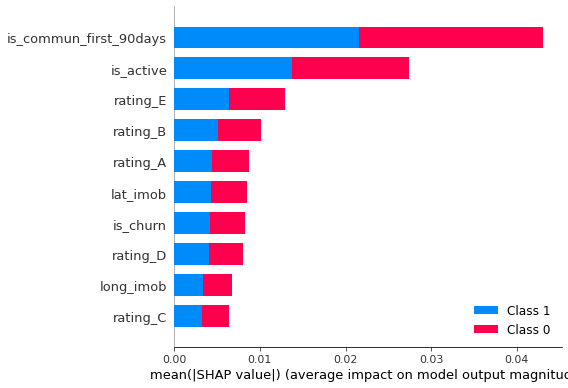

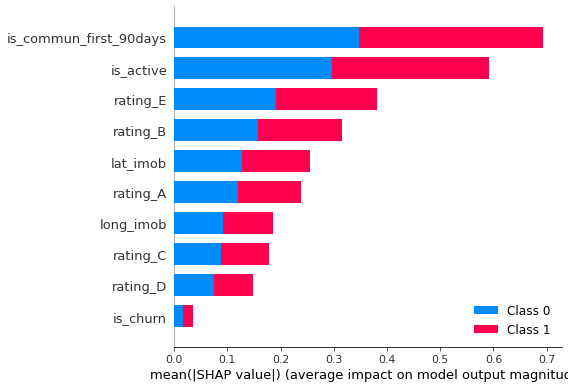

In [18]:
shap_et.summary_plot(plot_type="bar")
shap_lgbm.summary_plot(plot_type="bar")

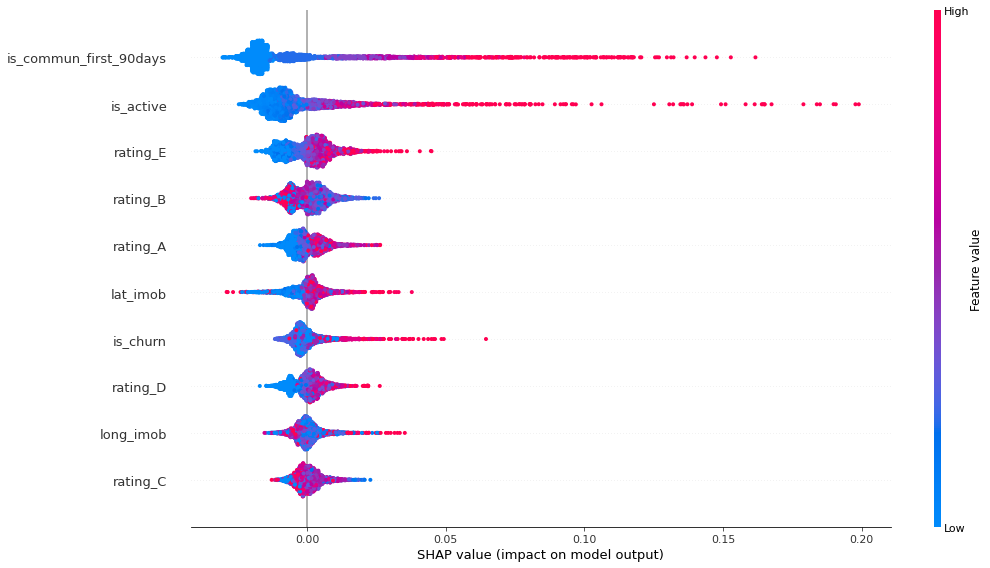

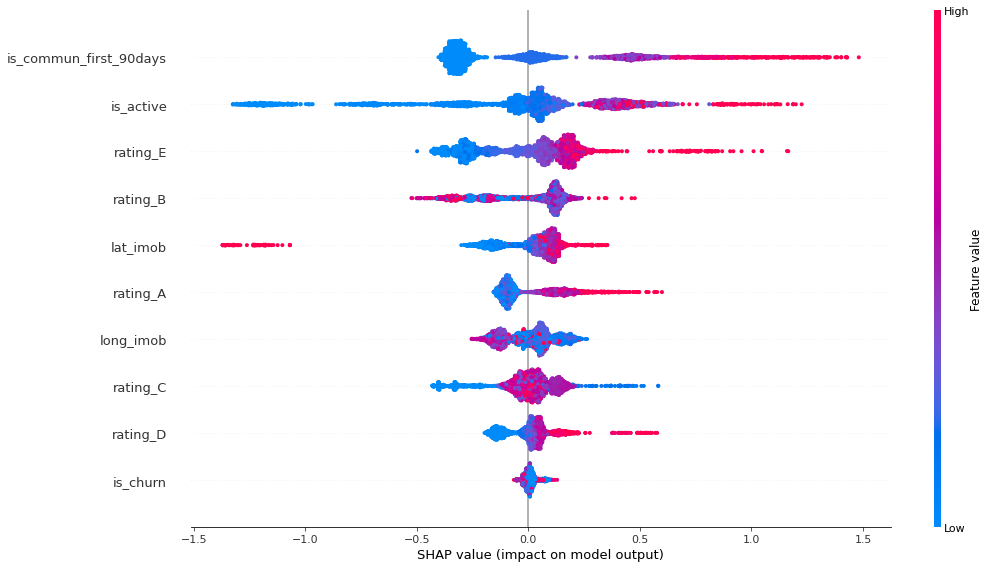

In [19]:
shap_et.summary_plot(plot_size=(15,8))
shap_lgbm.summary_plot(plot_size=(15,8))

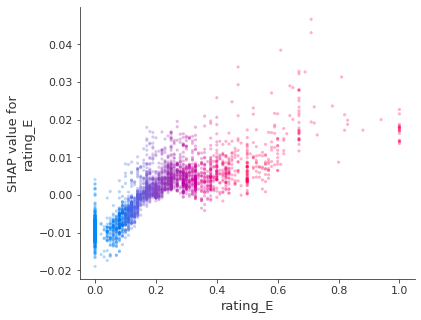

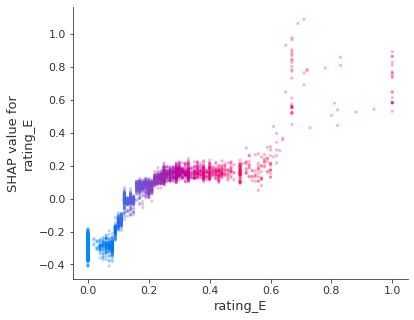

In [26]:
shap_et.dependence_plot(ind="rating_E", interaction_index="rating_E", alpha=0.3, dot_size=10)
shap_lgbm.dependence_plot(ind="rating_E", interaction_index="rating_E", alpha=0.3, dot_size=10)

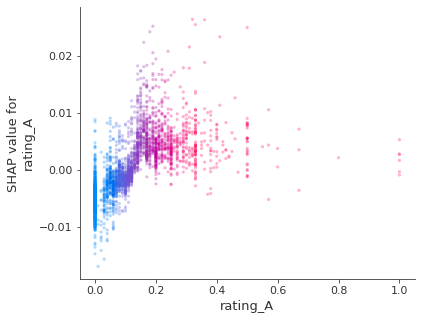

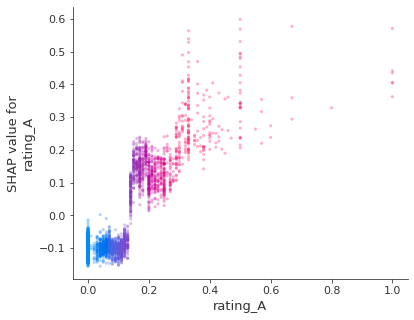

In [22]:
# A partir de 20% dos contratos ativados sendo E, aumenta o risco da imobiliária
shap_et.dependence_plot(ind="rating_A", interaction_index="rating_A", alpha=0.3, dot_size=10)
shap_lgbm.dependence_plot(ind="rating_A", interaction_index="rating_A", alpha=0.3, dot_size=10)

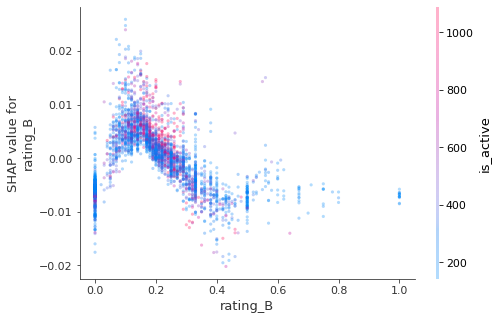

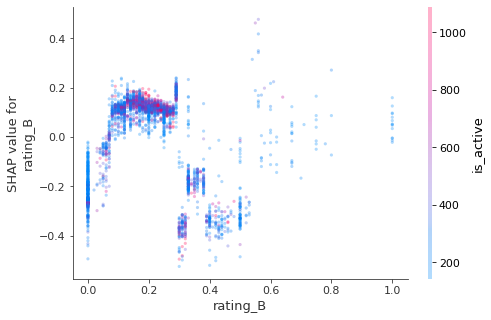

In [24]:
shap_et.dependence_plot(ind="rating_B", interaction_index="is_active", alpha=0.3, dot_size=10)
shap_lgbm.dependence_plot(ind="rating_B", interaction_index="is_active", alpha=0.3, dot_size=10)

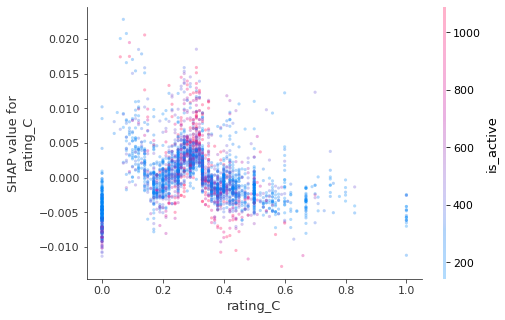

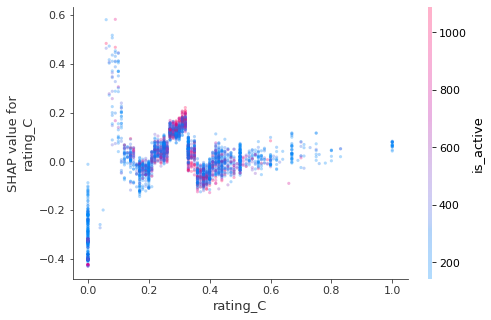

In [25]:
shap_et.dependence_plot(ind="rating_C", interaction_index="is_active", alpha=0.3, dot_size=10)
shap_lgbm.dependence_plot(ind="rating_C", interaction_index="is_active", alpha=0.3, dot_size=10)

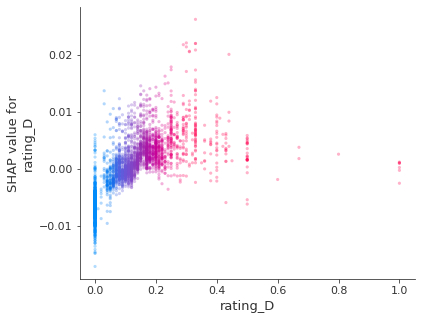

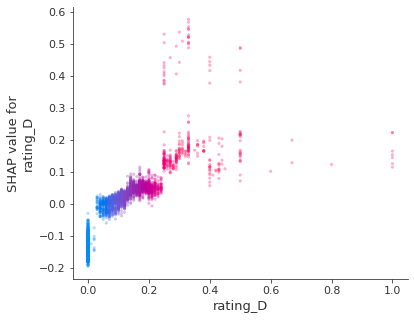

In [26]:
shap_et.dependence_plot(ind="rating_D", interaction_index="rating_D", alpha=0.3, dot_size=10)
shap_lgbm.dependence_plot(ind="rating_D", interaction_index="rating_D", alpha=0.3, dot_size=10)

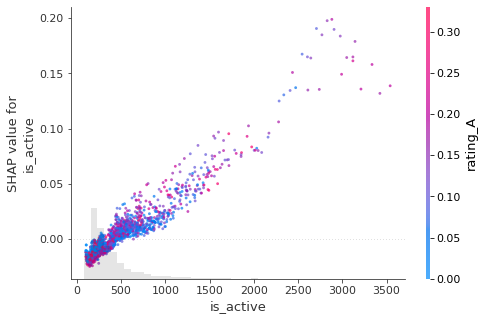

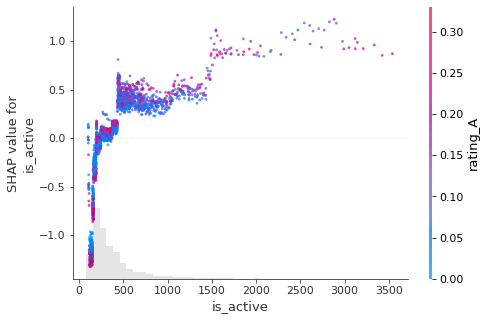

In [20]:
shap_et.scatter_plot(
    ["is_active", "rating_A"],
    dependence=True,
    dot_size=8,
    alpha=0.7
)

shap_lgbm.scatter_plot(
    ["is_active", "rating_A"],
    dependence=True,
    dot_size=8,
    alpha=0.7
)

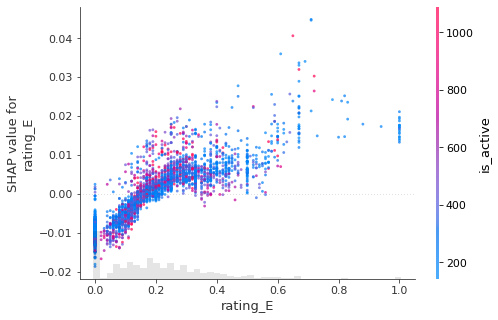

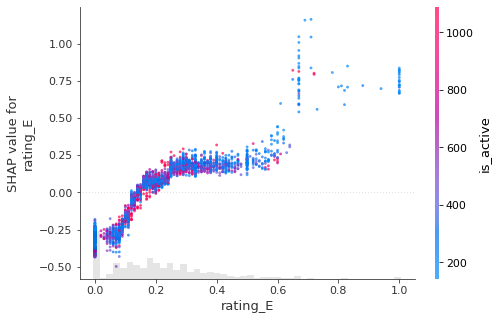

In [27]:
shap_et.scatter_plot(
    ["rating_E", "is_active"],
    dependence=True,
    dot_size=8,
    alpha=0.7
)

shap_lgbm.scatter_plot(
    ["rating_E", "is_active"],
    dependence=True,
    dot_size=8,
    alpha=0.7
)

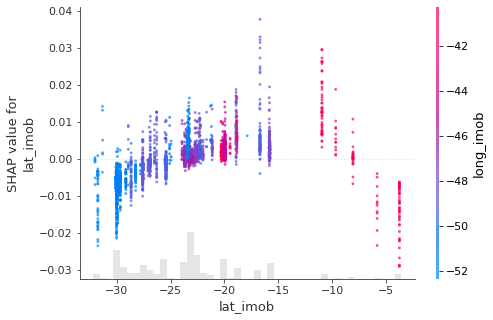

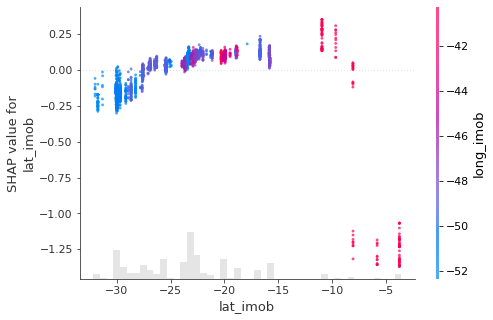

In [28]:
shap_et.scatter_plot(
    ["lat_imob", "long_imob"],
    dependence=True,
    dot_size=8,
    alpha=0.7
)

shap_lgbm.scatter_plot(
    ["lat_imob", "long_imob"],
    dependence=True,
    dot_size=8,
    alpha=0.7
)